<a href="https://colab.research.google.com/github/Shritej24c/NLP101/blob/main/HW/HW2/ShritejShrikant_file2_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color ='pickle'> Install/Import *Libraries*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.1 MB/s eta 0:00:00


In [43]:
# Import necessary libraries
import pandas as pd
from pathlib import Path

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import *
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_recall_curve, auc, make_scorer, cohen_kappa_score, balanced_accuracy_score, confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import spacy

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [5]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !python -m spacy download en_core_web_sm -qq
    !pip install -U scikit-optimize -qq

    basepath = '/content/drive/MyDrive/NLP/'
    sys.path.append('/content/drive/MyDrive/NLP/custom-functions')
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append(
        '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')

Mounted at /content/drive
2023-09-10 17:50:56.766502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP/custom-functions']

In [7]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/spam'
model_folder = base_folder/'models/spam'
custom_functions = base_folder/'custom-functions'


In [8]:
import custom_preprocessor_mod as cp
from featurizer import ManualFeatures
from plot_learning_curve import plot_learning_curve

## Load Dataset

Downloaded the dataset from here : https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [9]:
data = pd.read_csv(data_folder/'spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
data.shape

(5572, 5)

In [11]:
data.isnull().sum()


v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [12]:
data['v1'].value_counts()


ham     4825
spam     747
Name: v1, dtype: int64

In [13]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
data.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
data.head()



,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
data['label'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: label, dtype: float64

In [15]:
# prompt: convert above labels: 0 for 'ham' & 1 'spam for above dataset

data['label'].replace(['ham', 'spam'], [0, 1], inplace=True)
data['label'].value_counts(normalize=True)*100

0    86.593683
1    13.406317
Name: label, dtype: float64

In [16]:
print(data.shape)

print(data['label'].value_counts())

x = data['text']
y = data['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21, stratify=y, shuffle=True)


print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(5572, 2)
0    4825
1     747
Name: label, dtype: int64
(4457,) (1115,) (4457,) (1115,)
0    3859
1     598
Name: label, dtype: int64
0    966
1    149
Name: label, dtype: int64


In [17]:
xtrain = x_train.values
ytrain = y_train.values

xtest = x_test.values
ytest = y_test.values


print(xtrain.shape, ytrain.shape)




(4457,) (4457,)


## <font color ='pickle'> **Spacy**


In [18]:
# Spacy Tokenizer
# Loading the 'en_core_web_sm' language model from the spaCy library
nlp = spacy.load('en_core_web_sm')


disabled = nlp.select_pipes(
    disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])


def spacy_tokenizer(data):
    doc = nlp(data)
    return [token.text for token in doc]


cpp = cp.SpacyPreprocessor(
    model='en_core_web_sm')



def spacy_preprocessor(text):
    filtered_text = cpp.transform([text])
    return " ".join(filtered_text)



In [19]:
# save this to a file
X_train_cleaned = cpp.transform(xtrain)
file_X_train_cleaned_sparse_embed = data_folder / \
    'x_train_cleaned_sparse_embed_full.pkl'
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

/content/drive/MyDrive/NLP/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['/content/drive/MyDrive/NLP/datasets/spam/x_train_cleaned_sparse_embed_full.pkl']

In [20]:
X_test_cleaned = cpp.transform(xtest)
# save  this to a file
file_X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed_full.pkl'
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP/datasets/spam/x_test_cleaned_sparse_embed_full.pkl']

## <font color ='pickle'> Defining Class Weights for Imbalanced data to train Classifier

In [21]:
w = {}

w[1] = int(y_train.value_counts()[0]/ytrain.shape[0]*100)

w[0] = 100 - w[1]

print(w)

{1: 86, 0: 14}


## <font color ='pickle'>**Final Pipeline (Pipeline 3): Combine Manual Features and TfID vectors**

In [22]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [23]:
X_train_features, feature_names = featurizer.fit_transform(xtrain)

/content/drive/MyDrive/NLP/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [24]:
print(X_train_features.shape)
X_train_features[0:3]


(4457, 11)


array([[13.        , 58.        , 46.        ,  3.28571429,  0.        ,
         0.        ,  0.        ,  4.        ,  1.        ,  3.        ,
         0.        ],
       [13.        , 51.        , 39.        ,  2.78571429,  0.        ,
         0.        ,  0.        ,  1.        ,  3.        ,  3.        ,
         0.        ],
       [10.        , 53.        , 44.        ,  4.        ,  0.        ,
         0.        ,  0.        ,  3.        ,  0.        ,  1.        ,
         1.        ]])

In [25]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,sen tell go join uncle finance cbe,13.0,58.0,46.0,3.285714,0.0,0.0,0.0,4.0,1.0,3.0,0.0
1,reach home n bathe liao u,13.0,51.0,39.0,2.785714,0.0,0.0,0.0,1.0,3.0,3.0,0.0
2,hello site download song urgent pls,10.0,53.0,44.0,4.000000,0.0,0.0,0.0,3.0,0.0,1.0,1.0
3,hi:)ct employee,5.0,28.0,24.0,4.000000,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,aight pick open tonight,10.0,49.0,40.0,3.636364,0.0,0.0,1.0,2.0,1.0,2.0,0.0


In [26]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)


sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)



### <font color ='pickle'>**Create Final Pipeline**

In [27]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000, random_state=21, class_weight=w)),
                         ])


In [53]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV or some other methods

param_bayes_classifier_3 = {'combined_features__tfidf__tfidf__max_features': Integer(500, 10000),
                           #'combined_features__tfidf__tfidf__ngram_range': Categorical([(1, 1), (1, 2), (1, 3)]),
                           'combined_features__tfidf__tfidf__max_df': Real(0.2, 0.8),
                           'combined_features__tfidf__tfidf__min_df': Real(0.01, 0.05, prior='log-uniform'),
                           'classifier__solver': Categorical(['liblinear', 'saga', 'newton-cg', 'lbfgs']),

                           'classifier__C': Real(0.001, 1000, prior='log-uniform')
                           }

In [54]:

# Define a custom scoring function for PR AUC
def custom_pr_auc_scorer(y, y_proba):
    #y_proba = estimator.predict_proba(X)[:, 1]  # Probability of positive class
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    return pr_auc


# Define a custom scoring function for Cohen's Kappa
def custom_kappa_scorer(y, y_pred):
    kappa = cohen_kappa_score(y, y_pred)
    return kappa


# Use cross-validation with the custom scoring function
pr_auc_scorer = make_scorer(custom_pr_auc_scorer, greater_is_better=True)  # Set greater_is_better=True for higher PR AUC scores


# Use cross-validation with the custom scoring function
kappa_scorer = make_scorer(custom_kappa_scorer)

### <font color ='pickle'> Perform Bayesian Optimization

In [55]:
# Perform Bayesian optimization
optimizer3 = BayesSearchCV(estimator=classifier_3, search_spaces= param_bayes_classifier_3, n_iter=66, cv=5, n_jobs = -1, verbose = 1
                          , scoring=pr_auc_scorer
                           )


# Fit the model to the data
optimizer3.fit(X_train_final, ytrain)

# Print the best hyperparameters aand corresponding score
print("Best score:", optimizer3.best_score_)
print("Best hyperparameters:", optimizer3.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [56]:
print("Best cross-validation score: {:.2f}".format(optimizer3.best_score_))
print("\nBest parameters: ", optimizer3.best_params_)
print("\nBest estimator: ", optimizer3.best_estimator_)

Best cross-validation score: 0.93

Best parameters:  OrderedDict([('classifier__C', 0.17159080752918784), ('classifier__solver', 'newton-cg'), ('combined_features__tfidf__tfidf__max_df', 0.8), ('combined_features__tfidf__tfidf__max_features', 10000), ('combined_features__tfidf__tfidf__min_df', 0.01)])

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.8,
                                                                                   max_features=10000,
                                                                                   min_df=0.01))]),
                                                  

### <font color ='pickle'>**Save & Load Model**

In [57]:
file_best_estimator_pipeline3 = model_folder / \
    'logistic_final.pkl'
file_complete_bayes_pipeline3= model_folder / \
    'logistic_final_complete_bayes_full.pkl'

joblib.dump(optimizer3.best_estimator_, file_best_estimator_pipeline3)
joblib.dump(optimizer3, file_complete_bayes_pipeline3)


# load the saved model
best_estimator_pipeline3_round1 = joblib.load(
    file_best_estimator_pipeline3)
complete_bayes_pipeline3_round1 = joblib.load(
    file_complete_bayes_pipeline3)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

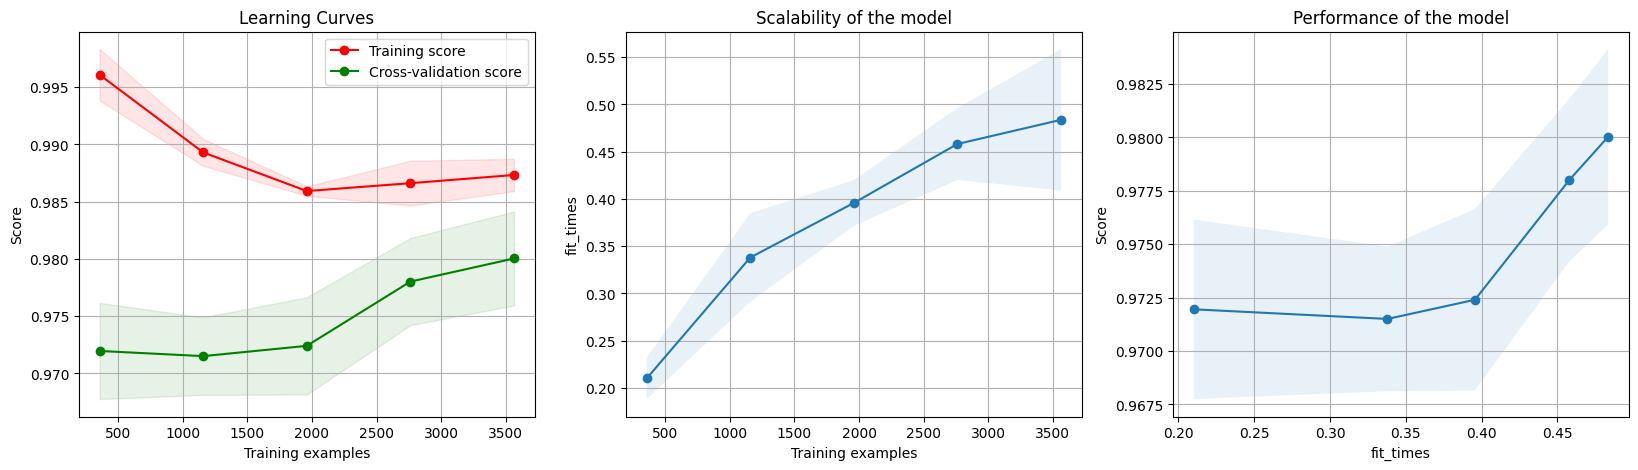

In [58]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, ytrain, n_jobs=-1)

In [59]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train))

# let's check the cross validation score
print(complete_bayes_pipeline3_round1.best_score_)

0.9847431007404084
0.931513850007699


In [60]:
X_train_final.shape

(4457, 12)

### <font color ='pickle'>**Evaluate on Test**

In [61]:
# Final Pipeline
def final_pipeline(text):
    cleaned_text = cpp.transform(text)
    # cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(
        file_best_estimator_pipeline3)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [62]:
# predicted values for Test data set
y_test_pred = final_pipeline(xtest)

/content/drive/MyDrive/NLP/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [63]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))



Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.98       966
           1       0.87      0.93      0.90       149

    accuracy                           0.97      1115
   macro avg       0.93      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [64]:
# prompt: plot confusion matrix

print(confusion_matrix(ytest, y_test_pred))

[[945  21]
 [ 10 139]]


In [65]:
print(custom_pr_auc_scorer(ytest, y_test_pred))

0.9053022579528697


In [66]:
print(balanced_accuracy_score(ytest, y_test_pred))


0.9555733878027429


### **Final Score on the Chosen Metric**

**Precision Recall AUC** - 0.9019822478991